Replace ZIP_FILE_PATH with the dataset location

---


[train_val.zip]
Downloaded from the SUIM dataset link: https://drive.google.com/drive/folders/10KMK0rNB43V2g30NcA1RYipL535DuZ-h

In [ ]:
import os

ZIP_FILE_PATH = "images.zip"
!unzip -q $ZIP_FILE_PATH

[images.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of images.zip or
        images.zip.zip, and cannot find images.zip.ZIP, period.


In [ ]:
!apt install file
!file images.zip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
file is already the newest version (1:5.41-3ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
images.zip: Zip archive data, at least v2.0 to extract, compression method=store


In [ ]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!7z e images.zip -o/content/drive/MyDrive/SUIM\ Dataset/train_val/images



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 56545280 bytes (54 MiB)

Extracting archive: images.zip
 47% 256 Open             
ERRORS:
Unexpected end of archive

--
Path = images.zip
Type = zip
ERRORS:
Unexpected end of archive
Physical Size = 56545280

 92%      3% 20 - images/n_l_23_.jpg                              7% 38 - images/n_l_91_.jpg                             11% 57 - images/f_r_1154_.jpg                               13% 76 - images/d_r_333_.jpg                              16% 94

In [ ]:
!rm /content/*.jpg


In [ ]:
!unzip "/content/drive/MyDrive/SUIM Dataset/train_val/images.zip" -d "/content/drive/MyDrive/SUIM Dataset/train_val"


Archive:  /content/drive/MyDrive/SUIM Dataset/train_val/images.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/drive/MyDrive/SUIM Dataset/train_val/images.zip or
        /content/drive/MyDrive/SUIM Dataset/train_val/images.zip.zip, and cannot find /content/drive/MyDrive/SUIM Dataset/train_val/images.zip.ZIP, period.


In [ ]:
!cp "/content/drive/MyDrive/SUIM Dataset/train_val/images.zip" "/content/"

In [ ]:
# Replace ROOT_DIR with the images directory
ROOT_DIR = "/content/drive/MyDrive/SUIM Dataset/train_val/images"

# Replace with the directory path where you wish to save the models
SAVE_DIR = "/content/drive/MyDrive/UAENet/saved_models"

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import os
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
print(len(os.listdir(ROOT_DIR)))

1525


In [ ]:
# 1. Define the UAE-Net Network
class UAENet(nn.Module):
    def __init__(self):
        super(UAENet, self).__init__()
        # Initial convolution layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=1, stride=1)

        # Depth-wise separable convolutions
        self.depthwise_conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, groups=32)
        self.pointwise_conv4 = nn.Conv2d(32, 32, kernel_size=1, stride=1)

        self.depthwise_conv5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, groups=32)
        self.pointwise_conv5 = nn.Conv2d(32, 32, kernel_size=1, stride=1)

        # Final convolutional layer with Tanh activation
        self.final_conv = nn.Conv2d(32, 3, kernel_size=1, stride=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Forward pass through convolutional layers
        x = F.leaky_relu(self.conv1(x), 0.1)
        x = F.leaky_relu(self.conv2(x), 0.1)
        x = F.leaky_relu(self.conv3(x), 0.1)

        # Depth-wise separable convolutions
        x = F.leaky_relu(self.pointwise_conv4(self.depthwise_conv4(x)), 0.1)
        x = F.leaky_relu(self.pointwise_conv5(self.depthwise_conv5(x)), 0.1)

        # Final output layer
        x = self.tanh(self.final_conv(x))
        return x

In [ ]:
def enhance_image(image, uaenet, iterations=8):
    """
    Apply the enhancement curve iteratively to the image.
    """
    for _ in range(iterations):
        image = image + uaenet(image) * image * (1 - image)
    return image

In [ ]:
def underwater_color_adaptive_correction_loss(enhanced, original):
    """
    Underwater color adaptive correction loss (Luac).
    """
    mean_original = original.mean(dim=[2, 3])  # Average over spatial dimensions
    mean_enhanced = enhanced.mean(dim=[2, 3])
    loss = sum((mean_original - mean_enhanced) ** 2).mean()
    return loss

In [ ]:
def exposure_control_loss(enhanced, E=0.43, M=32):
    """
    Exposure control loss (Lexp).
    """
    patch_size = M
    patches = enhanced.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patch_means = patches.mean(dim=[4, 5])  # Mean intensity for each patch
    loss = ((patch_means - E) ** 2).mean()
    return loss

In [ ]:
def illumination_smoothness_loss(curve_params):
    """
    Illumination smoothness loss (Ltvd).
    """
    # Slice tensors along both dimensions to get size-aligned tensors
    dx = torch.abs(curve_params[:, :, 1:, :] - curve_params[:, :, :-1, :])  # Slicing along height
    dy = torch.abs(curve_params[:, :, :, 1:] - curve_params[:, :, :, :-1])  # Slicing along width

    # Align the dimensions by using slicing
    loss = (dx[:, :, :, :-1] + dy[:, :, :-1, :]).mean()

    return loss

In [ ]:
def spatial_consistency_loss(enhanced, original):
    """
    Spatial consistency loss (Lspa).
    """
    dx_enhanced = enhanced[:, :, 1:, :] - enhanced[:, :, :-1, :]
    dy_enhanced = enhanced[:, :, :, 1:] - enhanced[:, :, :, :-1]

    dx_original = original[:, :, 1:, :] - original[:, :, :-1, :]
    dy_original = original[:, :, :, 1:] - original[:, :, :, :-1]

    loss = (
        (dx_enhanced[:, :, :, :-1] - dx_original[:, :, :, :-1]) ** 2 + \
     (dy_enhanced[:, :, :-1, :] - dy_original[:, :, :-1, :]) ** 2
        ).mean()
    return loss

In [ ]:
# Combine the losses
def total_loss(enhanced, original, curve_params, weights):
    """
    Total loss combining all the individual loss functions.
    """
    Luac = underwater_color_adaptive_correction_loss(enhanced, original)
    Lexp = exposure_control_loss(enhanced)
    Ltvd = illumination_smoothness_loss(curve_params)
    Lspa = spatial_consistency_loss(enhanced, original)

    return (
        weights['Luac'] * Luac +
        weights['Lexp'] * Lexp +
        weights['Ltvd'] * Ltvd +
        weights['Lspa'] * Lspa
    )

In [ ]:
# 4. Define the Custom Dataset Class
class UnderwaterDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, image  # Input and target images are the same for zero-reference tasks


In [ ]:
# Define the directory to save model checkpoints
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Save the model checkpoint
def save_checkpoint(model, epoch, save_dir):
    save_path = os.path.join(save_dir, f"uae_net_epoch_{epoch + 1}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Model saved at {save_path}")

# Modified training loop with model saving
def train_uaenet(model, dataloader, optimizer, num_epochs, device, weights, save_dir):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (input_images, target_images) in enumerate(dataloader):
            # Move the input and target images to the device (GPU or CPU)
            input_images = input_images.to(device)
            target_images = target_images.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass: Generate curve parameter maps using UAE-Net
            curve_params = model(input_images)

            # Enhance the input images iteratively
            enhanced_images = enhance_image(input_images, model)

            # Calculate the loss
            loss = total_loss(enhanced_images, target_images, curve_params, weights)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 10 == 9:  # Print every 10 batches
                print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 10:.4f}")
                running_loss = 0.0

        if epoch % 20 in (0, num_epochs-1):  # Save model checkpoint every 10 epochs
        # Save model at the end of each epoch
            save_checkpoint(model, epoch, save_dir)

        print(f"Epoch [{epoch + 1}/{num_epochs}] completed.")

    print("Training finished.")

In [ ]:
# Define hyperparameters
num_epochs = 50
learning_rate = 1e-4
batch_size = 16
weights = {
    'Luac': 1.0,    # Weight for underwater color adaptive correction loss
    'Lexp': 0.5,    # Weight for exposure control loss
    'Ltvd': 0.8,    # Weight for illumination smoothness loss
    'Lspa': 0.3     # Weight for spatial consistency loss
}

In [ ]:
# Initialize the model
model = UAENet().to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define data transformations (resize and normalize images)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Assuming you have a dataset like UnderwaterDataset, we need to split the indices.
dataset = UnderwaterDataset(root_dir=ROOT_DIR, transform=transform)

TEST_SIZE = 0.25

# Get indices for train-test split
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=TEST_SIZE, random_state=42)

# Create subsets for training and testing
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Now you can use train_loader for training and test_loader for validation or testing.
train_uaenet(model, train_loader, optimizer, num_epochs, device, weights, SAVE_DIR)

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 25.06 MiB is free. Process 5688 has 14.72 GiB memory in use. Of the allocated memory 14.60 GiB is allocated by PyTorch, and 1.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
torch.cuda.empty_cache()

<ipython-input-6-31178092fa2b>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Model loaded from /content/drive/MyDrive/UAENet/saved_models/uae_net_epoch_5.pth


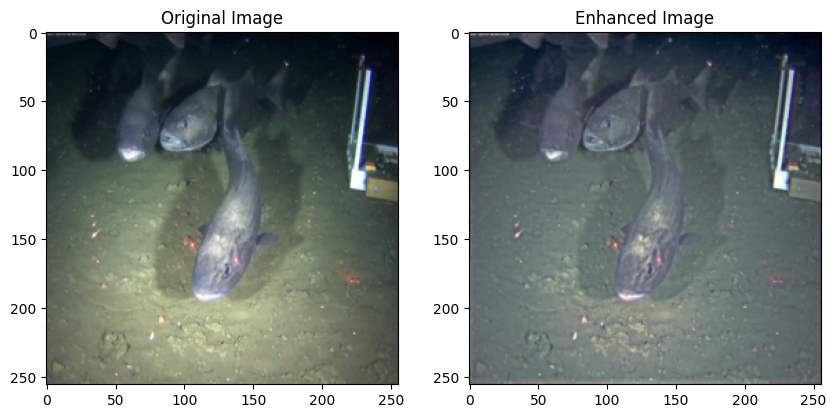

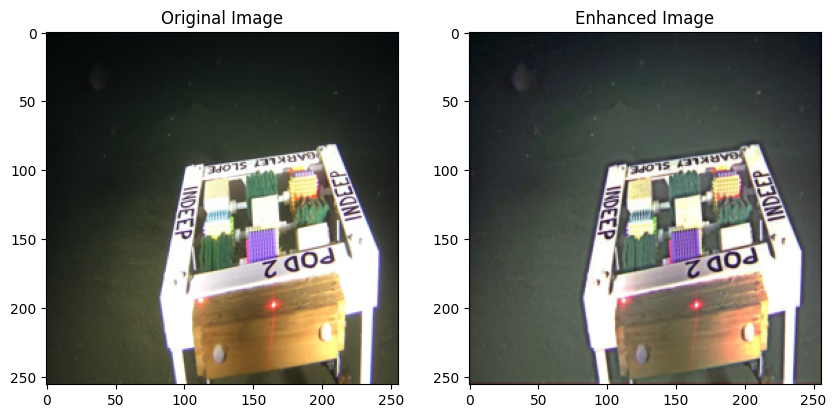

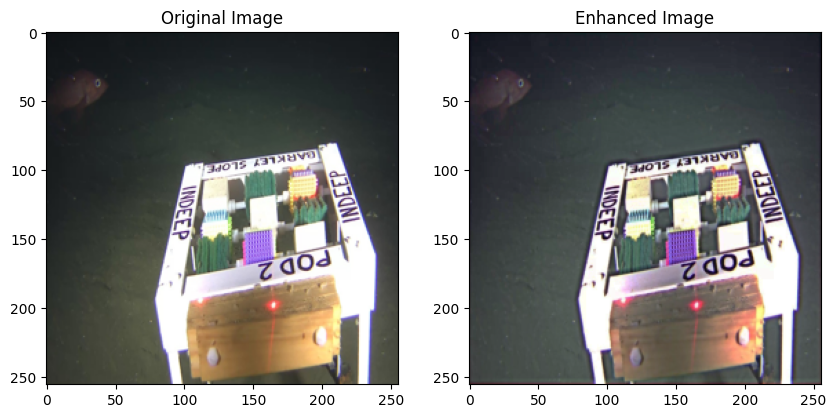

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the function to load the saved model
def load_model(model, checkpoint_path, device):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {checkpoint_path}")
    return model

# Function to preprocess input image (resize, normalize, convert to tensor)
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),  # Convert to tensor
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to post-process the output tensor and convert it back to an image
def postprocess_image(tensor):
    image = tensor.squeeze(0)  # Remove batch dimension
    image = image.detach().cpu().numpy().transpose(1, 2, 0)  # Convert to numpy and reshape
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
    return image

# Inference function to enhance an underwater image using the trained model
def run_inference(model, image_path, device):
    # Preprocess the image
    input_image = preprocess_image(image_path).to(device)

    # Perform inference using the trained model
    with torch.no_grad():
        enhanced_image = enhance_image(input_image, model, iterations=30)

    # Post-process the output image and convert it to a format that can be displayed
    enhanced_image_np = postprocess_image(enhanced_image)

    # Display the original and enhanced images side by side
    original_image = Image.open(image_path)
    original_image = original_image.resize((256, 256))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_image_np)
    plt.title('Enhanced Image')
    plt.show()

# Example of how to use the above functions for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UAENet()

# Load the trained model from the checkpoint
checkpoint_path = os.path.join(SAVE_DIR, "uae_net_epoch_5.pth")
model = load_model(model, checkpoint_path, device)

# Path to the underwater image you want to enhance
image_path = "/content/129.jpg"

# Run inference on the image and display the results
run_inference(model, image_path, device)


image_path = "/content/177.jpg"
run_inference(model, image_path, device)

image_path = "/content/165.jpg"
run_inference(model, image_path, device)

